# Getting your hands dirty with LDA (Using the Foursquare API)

First things first, we want to develop a classifier that can detect if a user comment is misapplied to the venue. Think of all the times you've gone to an Amazon item and saw reviews that looked like the image below, "Used but in very good condition", "fast shipping" are these relevant to a product review? Or are they more appropriate for seller reviews? 

We're going to see if we can develop a comment classifier to detect which kinds of comments may be more appropriate for which venue type, and thus provide some indication on the "appropriateness" of the comment that can be used for further review, thus (we hope), improving the overall quality of Foursquare as a reviews platform

As an example: "This place got me drunk" would be a comment you'd expect to see for a store category "bar" 
Yet, "I want to have my wedding here" is definitely not a comment you'd expect to see at a "bar" category, more likely you'd see such a category associated with a park, or other such venue. 

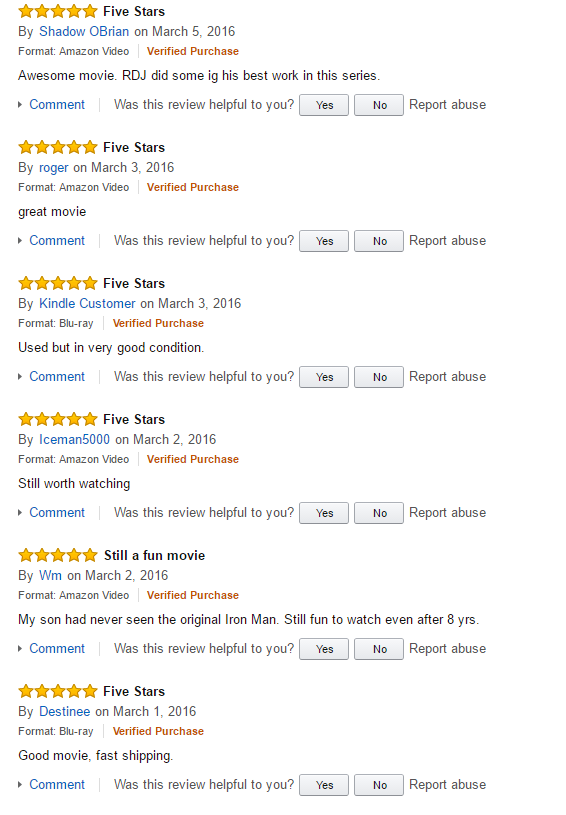

In [3]:
from IPython.display import Image
Image('../assets/images/amazon_image.png')

Use the previously built table-creator on a few categories of Foursquare venues. 

Find the category list code in the following page: https://developer.foursquare.com/categorytree

In [218]:
import foursquare
import json
import pandas as pd
import unicodedata

CLIENT_ID = 'VSLROL5XMTRYZK3RJSESVVMSMAV3WN1LJF1BEW2RIJCDQOTY'
CLIENT_SECRET = 'GKNMUYT1MLLJUBUZDG4KQ14YOMNZZBBIUAZBVGSBYYPAMKDX'
client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

Load all of your venues into a dataframe. Make sure that you have at least 4-6 categories of venues included in your data so we can seperate them out later with LDA.

In [228]:
start_cats = ['4bf58dd8d48988d130941735', '4d4b7105d754a06374d81259', '4d4b7105d754a06375d81259', '4d4b7104d754a06370d81259']
venue_ids = []
categories = []

for cat in start_cats:
    temp = client.venues.search(params={'limit':50, 'near': 'Seattle, WA', 'radius':'5000', 'categoryId': cat})
    x = json.dumps(temp, indent = 4)
    dicty = json.loads(x)
    for venue in dicty['venues']:
        venue_ids.append(venue['id'])
        categories.append(cat)

# Constructing features using string parsing and elementary text mining

Create a normalizer function that will take the comments, lowercase all uppercase letters, split each comment into an array/list/vector of words, and remove stop words. 

In [231]:
import re
import os
import codecs
from sklearn import feature_extraction
# import mpld3            
import numpy as np
from textblob import TextBlob


comments = []
count = 0
final_cats = []

for ID in venue_ids:
    venue_details = client.venues(VENUE_ID = ID)
    path_to_text = venue_details['venue']['tips']['groups'][0]['items']
    temp = []
    for comment in path_to_text:
        final_cats.append(categories[count])
        comments.append(comment['text'])
    count += 1

print len(final_cats)
print len(comments)

2630
2630


In [232]:
print pd.Series(final_cats).value_counts()

4d4b7104d754a06370d81259    950
4d4b7105d754a06374d81259    906
4d4b7105d754a06375d81259    565
4bf58dd8d48988d130941735    209
dtype: int64


In [278]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame()
df['category'] = final_cats
df['comments'] = comments

le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

df['category'].value_counts()

1    950
2    906
3    565
0    209
Name: category, dtype: int64

Write a normalizing method, one that will convert all letters in a string into lower case, and remove stopwords. 

In [171]:
# CountVectorizer does this.

Use the normalizer that you created to build a 'stripped' down comments array/vector/list (however you did it)

In [170]:
# CountVectorizer does this.

Vectorize your feature set into a dense matrix representation using Countvectorizer from sklearn

A helpful reference: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [327]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest

test = df[df['category'] != 0]

v = CountVectorizer(stop_words='english', 
                      token_pattern='[a-zA-Z]+', 
                      max_df=0.5, min_df=2)
X = pd.DataFrame(v.fit_transform(test['comments']).todense())
X.columns = v.get_feature_names()
y = test['category']

# Lots of data so lets select some of the more important stuff
kbest = SelectKBest(k=400)
kbest.fit_transform(X, y)

# boolean mask to get column names
mask = kbest.get_support()
voc = pd.DataFrame(np.asarray(v.get_feature_names())[mask])

# Vectorize with the vocab from above
v2 = CountVectorizer(vocabulary=voc[0])
X = pd.DataFrame(v2.fit_transform(test['comments']).todense())
X.columns = v2.get_feature_names()

# Performing the LDA

Construct your LDA with the pieces above by fitting the model to your feature set and target

In [5]:
import scipy

In [328]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split


lda = LDA(n_components=4)
# This gives us new features, components.
components = lda.fit_transform(X,y)
print lda.score(X, y)
y_pred = lda.predict(X)

0.745972738538


In [329]:
from sklearn.metrics import classification_report, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X.values, y, stratify=y, test_size=0.30, random_state=42)

lda = LDA(n_components=4)
components_2 = lda.fit_transform(X_train,y_train)
print lda.score(X_test, y_test)
y_pred = lda.predict(X_test)
print classification_report(y_test, y_pred)
confusion_matrix(y_test, y_pred)

0.65749656121
             precision    recall  f1-score   support

          1       0.59      0.75      0.66       285
          2       0.74      0.64      0.69       272
          3       0.68      0.53      0.60       170

avg / total       0.67      0.66      0.66       727



array([[214,  36,  35],
       [ 91, 174,   7],
       [ 55,  25,  90]])

# Visualizing Results

Now print the LDA and at least a few of the categories on a 2-D discriminant chart. Do you think the method is seperating the categories very well? Should we tune it more? Would it be a good indicator of "inappropriate commenting"? 

In [330]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

X_new = lda.transform(X)

array([[-0.45391788, -0.26405001],
       [-1.60037224, -0.27203291],
       [-3.04365346, -0.58223761],
       ..., 
       [-0.14086822,  1.86196741],
       [ 0.04194777,  0.16166685],
       [ 0.04194777,  0.16166685]])

In [333]:
plot_df = pd.concat([pd.DataFrame(X_new),y], axis=1)
plot_df.columns = ['c1', 'c2', 'y']
plot_df.dropna(inplace=True)
plot_df.head()

,c1,c2,y
209,-0.679503,-0.467204,2.0
210,-1.489442,-0.022694,2.0
211,-1.323663,-1.164915,2.0
212,-1.756263,0.305518,2.0
213,-0.940698,-0.389037,2.0


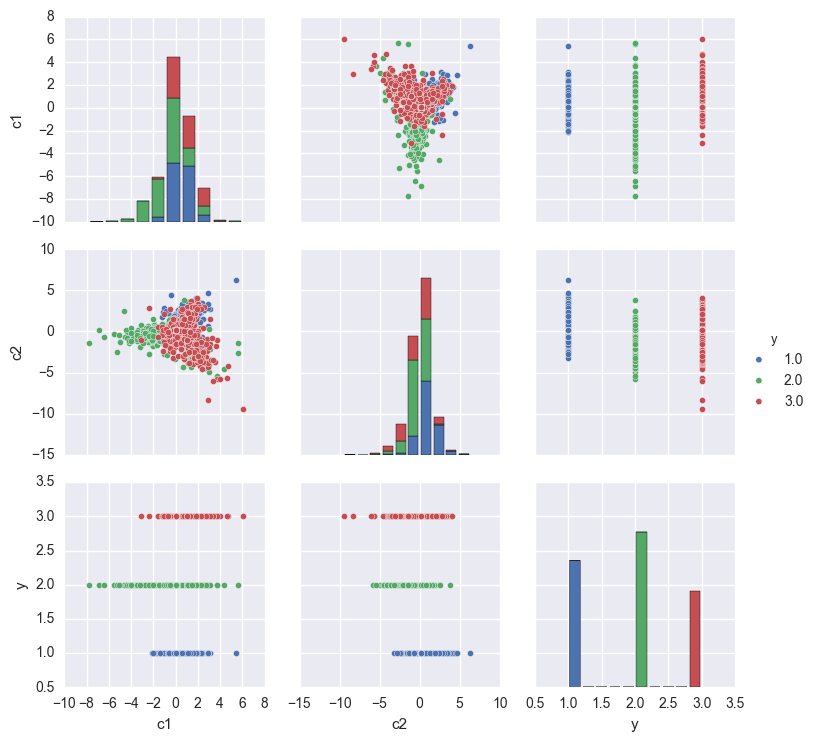

In [334]:
import seaborn as sns
sns.pairplot(plot_df, hue='y')